<a href="https://colab.research.google.com/github/michaelsong4399/asteroseismology/blob/master/NNLightCurveRSEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow
!pip install astropy
!pip install statsmodels

     |████████████████████████████████| 245kB 5.5MB/s 
     |████████████████████████████████| 6.5MB 18.4MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 256kB 50.9MB/s 
     |████████████████████████████████| 22.3MB 70.6MB/s 
     |████████████████████████████████| 788kB 47.9MB/s 
     |████████████████████████████████| 368kB 43.1MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 3.2MB 41.2MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp37-none-any.whl size=3831874 sha256=3920145014aac33ef37b5278d23944aca4c525f8c580c9caf23eb14adb1736db
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
  Created wheel for fbpca: filename=fbpca-1.0-cp37-none-any.whl size=11376 sha256=d4e95ce0ae829cf22553125d09ab30e4e557dfcd9e5390a3591b754d0ed00f67
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e

In [ ]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sklearn
import math
import scipy
import pandas as pd 
from scipy import interpolate
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
#sm
import statsmodels.api as sm

# ML Model

## Cycle Configs

In [ ]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5

cycle_2324 = [2450296.5,2458940.5]
        

## BiSON Surface Velocity - Import X

In [ ]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [ ]:
NOISE = False

if NOISE:
  noise = np.random.normal(0, 0.2*np.max(tsdata.T[1]), tsdata.T[1].shape)
  tsdata = np.array([tsdata.T[0],np.add(tsdata.T[1],noise).T]).T

In [ ]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

#test
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


## Sunspot Number - Import Y

In [ ]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [ ]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            if valid_count == 0:
              npout = np.append(npout,[[start,np.average(cycle)]],0)
            else:
              npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

#Test
getSN_Day(cycle_23)
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

## LOI Luminosity - Import Pred_Y

In [ ]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits')

hdul.info()

loidata = hdul[0].data

# variations at at most 2000 ppm
# cadence: 60s
LOI_DSTART =        2450174.50000 #Data start (Julian)      1 April 1996 0:00:00                        
LOI_DEND   =        2458589.50000 #Data end (Julian)        15 April 2019 0:00:00  

#    #23
# cycle_23 = [2450296.5,2454801.5]
        
#         #Start: 1 August 1996 2450296.5
#         #End: 1 December 2008 2454801.5
        
#     #24
# cycle_24 = [2454801.5,2458940.5]
        
#         #Start: 1 December 2008 2454801.5
#         #End: 1 May 2020 2458970.5


Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (12117600,)   float64   


In [ ]:
#Prepare LOI

if NOISE:
  noise = np.random.normal(0, 0.2*np.max(loidata), loidata.shape)
  loidata = np.add(loidata,noise)

loidatax = np.arange(LOI_DSTART,LOI_DEND,1/1440)
loifull = np.append([loidatax],[loidata],0).T
print(loifull.shape)

(12117600, 2)


In [ ]:
def getLOI(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,LOI_DSTART)
    
    #multiply by 1440 (1440 datapoints per day)
    cycle = np.multiply(cycle,1440)
    
    return loifull[int(cycle[0]):int(cycle[1])]

print(getLOI([2450174.5,2458590.5]).shape)

(12117600, 2)


## Helper Functions

In [ ]:
#Interpolation
def interpolate(data, smoothness):
    from scipy import interpolate
    x_new = np.linspace((data[0][0])-1,int(data[-1][0])+1,smoothness)
    a_BSpline = interpolate.make_interp_spline(data.T[0],data.T[1])
    y_new = a_BSpline(x_new)
    return x_new,y_new

In [ ]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [ ]:
def normalize2D(data,feature = None):
    threshold = 0.4
    data = np.asarray(data).T
    power = data[0:int(len(data)/2)].T
    freq = data[int(len(data)/2):].T
    data = power
    for i in range(int(len(data))):
        # Scale to 0-1
        if np.isnan(data[i]).all():
            data[i] = np.nan_to_num(data[i],np.nanmean(data[i-1]))
        else:
            data[i] = np.nan_to_num(data[i],np.nanmean(data[i-1] if i > 0 else 0))
            maximum = float(np.nanmax(data[i]))
            maximum = maximum if maximum not in ["nan",0] else 1
            data[i] = np.divide(data[i],maximum)

    # Remove < 0.4
    # for i in range(int(len(data))):
    #     for j in range(int(len(data[i]))):
    #         if data[i][j] < threshold:
    #           data[i][j] = 0

    # Frequency Normalization
    for i in range(int(len(freq))):
        # Scale to 0-1
        if np.isnan(freq[i]).all():
            freq[i] = np.nan_to_num(freq[i],np.nanmean(freq[i-1]))
        else:
            freq[i] = np.nan_to_num(freq[i],np.nanmean(freq[i-1] if i > 0 else 0))
            maximum = float(np.nanmax(freq[i]))
            maximum = maximum if maximum not in ["nan",0] else 1
            freq[i] = np.divide(freq[i],maximum)


    value = 1 if feature == "BiSON" else 0
    add = np.full((1,len(data)),value)
    # return np.append(add,np.append(data.T,freq,0),0).T
    return np.append(add,data.T,0).T

print(normalize2D([[1.0,2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11]],"BiSON"))

[[1.         0.2        0.4        0.6        0.8        1.        ]
 [1.         0.33333333 0.5        0.66666667 0.83333333 1.        ]]


In [ ]:
def removeNans(data):
  arr = data.T[1]
  arr[arr == 0] = 'nan'
  return [data.T[0],arr].T

## Lightkurve Asteroseismology - Functions

In [ ]:
def getPeriodogram(time,freq,numax=-1):
    lc = lk.LightCurve(time=time.tolist(),flux=freq.tolist())
    lc = lc.remove_nans()
    if numax != -1:
        pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=numax-500, maximum_frequency=numax+500) #-600, +1000
    else:
        pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=500, maximum_frequency=5000)
    #ax = pg.plot()
    return pg.flatten()

pg = getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000],3105)
print(pg.to_table())

    frequency              period                 power        
       uHz                1 / uHz                              
------------------ ---------------------- ---------------------
            2605.0 0.00038387715930902113    0.5183842828585827
2607.5002499119582  0.0003835090715844667   0.06818543899408096
2610.0004998239165  0.0003831416890791649    0.6750983499705479
2612.5007497358747 0.00038277500976836105     4.443719639554906
 2615.000999647833  0.0003824090316350441     3.829050619734312
 2617.501249559791  0.0003820437526699095     8.709403792707228
2620.0014994717494  0.0003816791708713229     16.14398284340772
2622.5017493837076  0.0003813152842452828    2.9357315757093776
 2625.001999295666  0.0003809520908053851    1.0190896447020263
 2627.502249207624  0.0003805895885727862     1.875493760940966
               ...                    ...                   ...
 3580.097465663712 0.00027932200438420484     1.176656488453895
  3582.59771557567  0.000279127069068460

In [ ]:
def getPower(pg):
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T#.tolist()
    return data

ptest = getPower(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000]))[0:5]
print(ptest)

[1.8647114  0.60279692 0.25367425 0.61840873 0.11310825]


In [ ]:
def getModes(pg,deltanu):
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T#.tolist()
    length = int(len(data)/15) #15
    out = []
    outindex = []
    for i in range(0,int(len(data))-10,length):
        highest = -100
        highestindex = 0
        for j in range(i,min(int(len(data)),i+length)):
            if data[j] >= highest:
                highest = data[j]
                highestindex = j-i
        outindex = np.append(outindex,highestindex)
        out = np.append(out,highest)

    return np.append(out,outindex)

mtest = getModes(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000],3105.0),135.231610746949)
print(mtest,mtest.shape)
        

[16.14398284 28.9110643  42.96931075 79.67117142 25.97593252 41.13780699
 13.82713721 13.20238083 91.0264496  16.81150796 22.77728573  7.93711392
 23.87083736 22.94008291 17.98447853  6.          9.         12.
 11.         10.         14.         15.         15.         17.
 17.         15.         19.         22.         21.         21.        ] (30,)


In [ ]:
def getNumax(pg):
  snr = pg.flatten()
  seis = snr.to_seismology()
  numax = float(str(seis.estimate_numax())[:-6])
  deltanu = float(str(seis.estimate_deltanu(numax=numax))[:-6])

  return numax,deltanu

nutest,deltanu = getNumax(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000]))
print(nutest,deltanu)

3105.0 135.231610746949


In [ ]:
def tsPower(time,freq,length,interval,BiSON=False):
  if BiSON:
      length = int(length * 2160)
      interval = int(interval * 2160)
  else:
      length = int(length * 1440)
      interval = int(interval * 1440)
  
  numax,deltanu = getNumax(getPeriodogram(time[:500000],freq[:500000]))

  check = True
  for start in range(0,len(time),interval):
      if start + length >= len(time):
          length = len(time) - start
      if check:
        check = False
        npout1d = np.array([getModes(getPeriodogram(time[start:start+length],freq[start:start+length],numax),deltanu)])
      else:
        temp = np.array([getModes(getPeriodogram(time[start:start+length],freq[start:start+length],numax),deltanu)])
        if temp.size == npout1d[-1].size:
          npout1d = np.append(npout1d,temp,0)


  return npout1d,numax

In [ ]:
def toLightCurve(time,freq):
  return lk.LightCurve(time=time,flux=freq)

In [ ]:
def toData(lc):
    lc_data = lc.to_table()
    data = np.array(lc_data['flux'])
    


## Model Preprocessing

### BiSON Surface Velocity - Preprocess X

In [ ]:
BiSON_ts_23,BiSON_numax_23= tsPower(getSV_index(cycle_23),getSV(cycle_23),90,30,True)

In [ ]:
print(BiSON_numax_23,BiSON_ts_23.shape)
print(BiSON_ts_23[:5])

3005.0 (150, 30)
[[115.27197433  76.24804261 218.81762513  88.18222376 129.31946428
  181.54922494 147.02860713 144.11885917 148.548598   125.07438946
  189.3807417   97.61721604  65.17035864  79.52131513  87.76847738
  427.         448.         423.         393.         437.
  409.         459.         408.         474.         497.
  487.         505.         495.         471.         514.        ]
 [120.66220742 109.53475563 127.19569676  80.11389879 150.2618182
  204.94065549 113.61672557  97.82269348 113.76414317 143.28014219
  116.82270082  78.80519079  81.95511619  63.92859124  60.67534495
  427.         453.         423.         461.         438.
  405.         457.         486.         462.         424.
  487.         514.         501.         471.         511.        ]
 [104.05341892  98.45097456 137.42725953  69.88116591 192.39534396
  182.4948956  121.17380806  91.19191074 101.75213002  59.80012173
  196.81588387  42.51882659  86.04682186  43.93645428  55.17343517
  417.   

In [ ]:
BiSON_ts_24,BiSON_numax_24 = tsPower(getSV_index(cycle_24),getSV(cycle_24),90,30,True)

In [ ]:
print(BiSON_numax_24,BiSON_ts_24.shape)
print(BiSON_ts_24[:5])

3025.0 (137, 30)
[[ 84.86662088  51.03536712 113.60531887  81.43405157 128.10329102
  118.28566566 134.75091985  91.60489569 221.00072168  52.79489883
   53.34352287  52.51274613  72.01857869  49.56080134  62.42520382
  269.         294.         271.         237.         285.
  236.         297.         332.         313.         271.
  321.         286.         345.         304.         361.        ]
 [ 77.91431246  62.99781227  97.54806691  73.75741947 166.39962977
  113.07462735 146.32364098  99.18414796 139.34606057  82.26319154
  132.98131872  97.33710556  43.56013535  36.00319535  34.11817082
  267.         294.         276.         307.         287.
  246.         297.         328.         313.         271.
  326.         297.         340.         376.         357.        ]
 [ 37.48598009  66.01676526  75.80278167  71.69749719 130.69510933
   92.61934843 161.51765926 142.496191    71.97323922 134.5011945
  118.17716203  88.3217759   50.80259049  36.34092725  26.37661252
  267.   

In [ ]:
BiSON_ts_full,BiSON_numax_full = tsPower(getSV_index(cycle_2324),getSV(cycle_2324),90,30,True)

/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [ ]:
print(BiSON_numax_full,BiSON_ts_full.shape)
print(BiSON_ts_full[:5])

3005.0 (288, 30)
[[115.27197433  76.24804261 218.81762513  88.18222376 129.31946428
  181.54922494 147.02860713 144.11885917 148.548598   125.07438946
  189.3807417   97.61721604  65.17035864  79.52131513  87.76847738
  427.         448.         423.         393.         437.
  409.         459.         408.         474.         497.
  487.         505.         495.         471.         514.        ]
 [120.66220742 109.53475563 127.19569676  80.11389879 150.2618182
  204.94065549 113.61672557  97.82269348 113.76414317 143.28014219
  116.82270082  78.80519079  81.95511619  63.92859124  60.67534495
  427.         453.         423.         461.         438.
  405.         457.         486.         462.         424.
  487.         514.         501.         471.         511.        ]
 [104.05341892  98.45097456 137.42725953  69.88116591 192.39534396
  182.4948956  121.17380806  91.19191074 101.75213002  59.80012173
  196.81588387  42.51882659  86.04682186  43.93645428  55.17343517
  417.   

### Sunspot Number - Preprocess Y

In [ ]:
SN_DELETE = -3

In [ ]:
SN_ts_23 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),30)[:SN_DELETE]
print(SN_ts_23.shape)

(148, 2)


In [ ]:
SN_ts_24 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),30)[:SN_DELETE]
print(SN_ts_24.shape)

(135, 2)


In [ ]:
SN_ts_full = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_2324),0),30)[:SN_DELETE]
print(SN_ts_full.shape)

(286, 2)


### LOI Luminosity - Preprocess Pred_Y

In [ ]:
print(getLOI(cycle_23).shape)
print(getLOI(cycle_23)[:10])

(6487200, 2)
[[ 2.45029650e+06 -2.08807224e-04]
 [ 2.45029650e+06 -1.99935382e-04]
 [ 2.45029650e+06 -2.12478601e-04]
 [ 2.45029650e+06 -2.09473520e-04]
 [ 2.45029650e+06 -2.38117448e-04]
 [ 2.45029650e+06 -2.55843421e-04]
 [ 2.45029650e+06 -2.29274237e-04]
 [ 2.45029650e+06 -2.39407792e-04]
 [ 2.45029651e+06 -2.34207347e-04]
 [ 2.45029651e+06 -1.84112930e-04]]


In [ ]:
LOI_ts_23,LOI_numax_23= tsPower(getLOI(cycle_23).T[0],getLOI(cycle_23).T[1],90,30)

/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [ ]:
print(LOI_numax_23,LOI_ts_23.shape)
print(LOI_ts_23[0:5])

3135.0 (150, 30)
[[ 47.98165651  23.10740797  78.44157143  51.93608801  61.38520253
   48.64217823  58.59022828  34.04069843  63.18077303  37.83090253
   55.29990935  36.36982317  28.94200752  46.48183635  17.65381014
  448.         486.         468.         434.         484.
  439.         495.         446.         506.         476.
   12.           8.          34.          21.          60.        ]
 [ 41.56048388  27.89874246 107.8765242   47.27836807  49.63243748
   66.11715255  52.73826855  36.84224164  62.34785886  27.15823236
   50.91744357  46.81299229  20.71633558  33.4645546   14.53521015
  454.         484.         468.         430.         482.
  511.         487.         449.           3.           0.
   21.          19.          32.          18.          44.        ]
 [ 34.48446171  33.20358558 110.47526211  55.6160969   46.18263259
   56.46611957 110.54428944  24.2185684  103.52306104  31.45599955
   29.20774667  44.02909883  30.94079121  26.86141092  12.96988363
  449.  

In [ ]:
LOI_ts_24,LOI_numax_24= tsPower(getLOI(cycle_24).T[0],getLOI(cycle_24).T[1],90,30)

In [ ]:
print(LOI_numax_24,LOI_ts_24.shape)
print(LOI_ts_24[0:5])

3115.0 (125, 30)
[[ 18.01916051  47.3493574   27.97056836 107.28512022  52.53455023
  138.03631513 103.14769172 228.16979872  47.28110525  90.2007494
   60.99721502  54.01090112  36.21008135  56.78275268  25.47494954
  115.          89.          46.         103.          68.
  115.         150.         131.         157.         148.
  104.         163.         192.         179.         155.        ]
 [ 36.45337049  73.59710752  39.30346327  71.04262191  64.62528035
  132.29327224  90.47491164 163.44013829  55.3788672  189.85460934
   61.87798426  32.59033862  32.72389682  33.13007803  24.0597421
  112.          94.         125.         103.         141.
  115.         146.         131.          84.         144.
  115.         158.         193.         179.         190.        ]
 [ 28.83899276  43.59731323  61.72215206  50.50501861  72.41713901
  110.1620372  141.92900246 128.13712044  76.86503396 229.78985597
   73.8175273   63.72149339  31.75459224  34.14024545  22.1238411
  115.     

In [ ]:
LOI_ts_full,LOI_numax_full= tsPower(getLOI(cycle_2324).T[0],getLOI(cycle_2324).T[1],90,30)

/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [ ]:
print(LOI_numax_full,LOI_ts_full.shape)
print(LOI_ts_full[0:5])

3135.0 (275, 30)
[[ 47.98165651  23.10740797  78.44157143  51.93608801  61.38520253
   48.64217823  58.59022828  34.04069843  63.18077303  37.83090253
   55.29990935  36.36982317  28.94200752  46.48183635  17.65381014
  448.         486.         468.         434.         484.
  439.         495.         446.         506.         476.
   12.           8.          34.          21.          60.        ]
 [ 41.56048388  27.89874246 107.8765242   47.27836807  49.63243748
   66.11715255  52.73826855  36.84224164  62.34785886  27.15823236
   50.91744357  46.81299229  20.71633558  33.4645546   14.53521015
  454.         484.         468.         430.         482.
  511.         487.         449.           3.           0.
   21.          19.          32.          18.          44.        ]
 [ 34.48446171  33.20358558 110.47526211  55.6160969   46.18263259
   56.46611957 110.54428944  24.2185684  103.52306104  31.45599955
   29.20774667  44.02909883  30.94079121  26.86141092  12.96988363
  449.  

## Align Dims

In [ ]:
# Cycle 23 Dims
print("Cycle 23 Dims")
try:
  print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)
except:
  pass
print()

# Cycle 24 Dims
print("Cycle 24 Dims")
try:
  print(BiSON_ts_24.shape,SN_ts_24.shape,LOI_ts_24.shape)
except:
  pass
print()

# Full Cycle Dims
print("Cycle FULL Dims")
try:
  print(BiSON_ts_full.shape,SN_ts_full.shape,LOI_ts_full.shape)
except:
  pass
print()

Cycle 23 Dims
(150, 30) (148, 2) (150, 30)

Cycle 24 Dims
(137, 30) (135, 2) (125, 30)

Cycle FULL Dims
(288, 30) (286, 2) (275, 30)



In [ ]:
#Fitting dims to LOI due to missing end of cycle 24
BiSON_ts_24_fit = BiSON_ts_24[:len(LOI_ts_24)]
SN_ts_24_fit = SN_ts_24[:len(LOI_ts_24)]

BiSON_ts_full_fit = BiSON_ts_full[:len(LOI_ts_full)]
SN_ts_full_fit = SN_ts_full[:len(LOI_ts_full)]

In [ ]:
# Test Fitted Dims
# Cycle 23 Dims
print("Cycle 23 Dims")
try:
  print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)
except:
  pass
print()

# Cycle 24 Dims
print("Cycle 24 Dims")
try:
  print(BiSON_ts_24_fit.shape,SN_ts_24_fit.shape,LOI_ts_24.shape)
except:
  pass
print()

# Full Cycle Dims
print("Cycle FULL Dims")
try:
  print(BiSON_ts_full_fit.shape,SN_ts_full_fit.shape,LOI_ts_full.shape)
except:
  pass
print()

Cycle 23 Dims
(150, 30) (148, 2) (150, 30)

Cycle 24 Dims
(125, 30) (125, 2) (125, 30)

Cycle FULL Dims
(275, 30) (275, 2) (275, 30)



## Model Architecture

In [ ]:
#Load Data
tLOI = normalize2D(LOI_ts_full,"LOI")#.T[:16].T
tBiSON = normalize2D(BiSON_ts_full_fit,"BiSON")#.T[:16].T
print(np.max(tLOI),np.max(tBiSON))
print(tLOI.shape,tBiSON.shape)

ty2 = np.append(normalize1D(SN_ts_full_fit.T[1]),normalize1D(SN_ts_full_fit.T[1]),0)


tx = np.append(tBiSON,tLOI,0) #BiSON_ts_full_fit
ty = ty2
print(tx.shape,ty.shape)

train_x,test_x,train_y,test_y=train_test_split(tx, ty, test_size=0.20, random_state=42)
train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
test_x = test_x.reshape(test_x.shape[0],1,test_x.shape[1])

# train_x = train_x[..., None]
# test_x = test_x[..., None]
print(train_x.shape,test_x.shape)

print(np.max(train_x),np.max(train_y),np.max(test_x),np.max(test_y))

1.0 1.0
(275, 16) (275, 16)
(550, 16) (550,)
(440, 1, 16) (110, 1, 16)
1.0 1.0 1.0 0.9484691088026244


In [ ]:
print(train_x[12])

[[0.         0.5281824  0.37758137 0.73481042 0.68895881 0.84214408
  0.93320187 0.91239361 0.37330112 1.         0.19775474 0.34408754
  0.40206268 0.37674197 0.23723085 0.14688365]]


In [ ]:
# tf.test.gpu_device_name() # No GPU Sad :v
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
model.add(layers.Dense(2048, activation='relu', input_shape=(train_x.shape)))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(4, activation="relu"))
# model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 440, 1, 2048)      34816     
_________________________________________________________________
dense_1 (Dense)              (None, 440, 1, 1024)      2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 440, 1, 512)       524800    
_________________________________________________________________
dense_3 (Dense)              (None, 440, 1, 256)       131328    
_________________________________________________________________
dense_4 (Dense)              (None, 440, 1, 32)        8224      
_________________________________________________________________
dense_5 (Dense)              (None, 440, 1, 4)         132       
_________________________________________________________________
dense_6 (Dense)              (None, 440, 1, 1)         5

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
        patience=30, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
history = model.fit(train_x, train_y, epochs=1000,
                   validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)

Epoch 1/1000
14/14 - 2s - loss: 0.0684 - accuracy: 0.0000e+00 - val_loss: 0.0534 - val_accuracy: 0.0000e+00
Epoch 2/1000
14/14 - 1s - loss: 0.0550 - accuracy: 0.0000e+00 - val_loss: 0.0472 - val_accuracy: 0.0000e+00
Epoch 3/1000
14/14 - 1s - loss: 0.0481 - accuracy: 0.0000e+00 - val_loss: 0.0470 - val_accuracy: 0.0000e+00
Epoch 4/1000
14/14 - 1s - loss: 0.0493 - accuracy: 0.0000e+00 - val_loss: 0.0444 - val_accuracy: 0.0000e+00
Epoch 5/1000
14/14 - 1s - loss: 0.0452 - accuracy: 0.0023 - val_loss: 0.0445 - val_accuracy: 0.0000e+00
Epoch 6/1000
14/14 - 1s - loss: 0.0441 - accuracy: 0.0023 - val_loss: 0.0412 - val_accuracy: 0.0000e+00
Epoch 7/1000
14/14 - 1s - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 8/1000
14/14 - 1s - loss: 0.0423 - accuracy: 0.0023 - val_loss: 0.0411 - val_accuracy: 0.0000e+00
Epoch 9/1000
14/14 - 1s - loss: 0.0405 - accuracy: 0.0023 - val_loss: 0.0452 - val_accuracy: 0.0000e+00
Epoch 10/1000
14/14 - 1s - loss: 0.0393 - ac

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/ML/p010')

## Model Prediction

In [ ]:
# Load Prediction Data
pred_BiSON = normalize2D(BiSON_ts_full_fit,"BiSON")#.T[16:].T
pred_LOI = normalize2D(LOI_ts_full,"LOI")#.T[16:].T
print(np.max(pred_BiSON),np.max(pred_LOI))
pred_BiSON = np.subtract(pred_BiSON.reshape(pred_BiSON.shape[0],1,pred_BiSON.shape[1]),0)
pred_LOI = np.subtract(pred_LOI.reshape(pred_LOI.shape[0],1,pred_LOI.shape[1]),0)
# pred_BiSON = normalizePred(pred_BiSON)
# pred_LOI = normalizePred(pred_LOI)
print(train_x.shape,test_x.shape)

1.0 1.0
(440, 1, 16) (110, 1, 16)


In [ ]:
pred_BiSON = model.predict(pred_BiSON)
print(pred_BiSON.shape)
pred_BiSON = pred_BiSON.reshape(-1)
print(pred_BiSON.shape)
print(pred_BiSON[0])
pred_LOI = model.predict(pred_LOI).reshape(-1)
print(pred_LOI[0:15])
# for i in range(0,int(len(pred_LOI)/2)):
#   if pred_LOI[i] >= 0.8:
#     pred_LOI[i] = pred_LOI[i-1]
# for i in range(int(len(pred_LOI)/2),len(pred_LOI)):
#   if pred_LOI[i] >= 0.55:
#     pred_LOI[i] = pred_LOI[i-1]

(275, 1, 1)
(275,)
0.23974918
[0.37153634 0.15761971 0.06412345 0.17747514 0.17864358 0.20520018
 0.2387127  0.28046778 0.40133554 0.3174602  0.2044762  0.15222326
 0.21681653 0.26322612 0.19971253]


In [ ]:
def normalizePred(data):
  data = np.subtract(data,np.min(data))
  data = np.divide(data,np.max(data))
  return data

(275,) (275,)
2450296.5 2458516.5


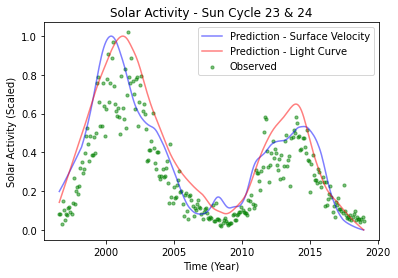

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (Year)')
plt.title('Solar Activity - Sun Cycle 23 & 24')

print(pred_BiSON.shape, SN_ts_full_fit.T[0].shape)
print(SN_ts_full_fit.T[0][0],SN_ts_full_fit.T[0][-1])
pred_x = np.arange(1996.586,2019.008,(2019.008-1996.586)/len(SN_ts_full_fit.T[0]))

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Solar Activity (Scaled)')
#axis_1.scatter(pred_x,pred_BiSON, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
#x1_ITP, y1_ITP = interpolate(np.array([pred_x,pred_BiSON]).T,140)
ITP_BiSON = sm.nonparametric.lowess(pred_BiSON,pred_x,frac=0.15).T
axis_1.plot(ITP_BiSON[0],normalizePred(ITP_BiSON[1]), c='blue', alpha=0.5, label = "Prediction - Surface Velocity")

# #Axis 2
# axis_2 = axis_1.twinx()
#axis_2.set_ylabel('LOI (Scaling)')
#axis_1.scatter(pred_x,pred_LOI, s = 10, c='red', alpha=0.5, label="pred_LOI")
#x2_ITP, y2_ITP = interpolate(np.array([pred_x,pred_LOI]).T,140)
ITP_LOI = sm.nonparametric.lowess(pred_LOI,pred_x,frac=0.15).T
axis_1.plot(ITP_LOI[0], normalizePred(ITP_LOI[1]), c='red', alpha=0.5, label = "Prediction - Light Curve")

#Axis 3
#axis_3 = axis_1.twinx()
#axis_3.axis("off")
#axis_3.set_ylabel('SN')
axis_1.scatter(pred_x,np.add(normalizePred(SN_ts_full_fit.T[1]),0.02), s = 10, c='green', alpha=0.5, label="Observed")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
#lines_2, labels_2 = axis_2.get_legend_handles_labels()
#lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1
labels = labels_1
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.savefig('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Graphs/BiSON_LOI_SN.png')
plt.show()

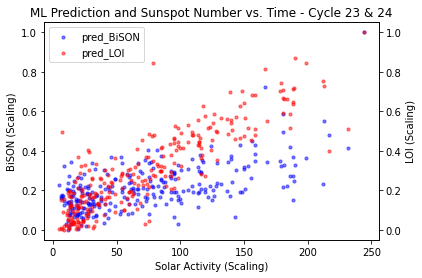

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Solar Activity (Scaling)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('BiSON (Scaling)')
axis_1.scatter(SN_ts_full_fit.T[1],normalizePred(pred_BiSON), s = 10, c='blue', alpha=0.5, label="pred_BiSON")

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('LOI (Scaling)')
axis_2.scatter(SN_ts_full_fit.T[1],normalizePred(pred_LOI), s = 10, c='red', alpha=0.5, label="pred_LOI")

# #Axis 3
# axis_3 = axis_1.twinx()
# axis_3.axis("off")
# axis_3.set_ylabel('SN')
# axis_3.scatter(datax_SN,datay_SN, s = 10, c='green', alpha=0.5, label="actual_SN")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
# lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 #+ lines_3
labels = labels_1 + labels_2 #+ labels_3
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.savefig('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Graphs/BiSON_LOI_SN.png')
plt.show()

In [ ]:
sn_ts_full_fit_norm = normalize1D(SN_ts_full_fit.T[1])
BiSONxSN_mse = np.sqrt(mean_squared_error(sn_ts_full_fit_norm,pred_BiSON))
BiSONxSN_mae = mean_absolute_error(sn_ts_full_fit_norm,pred_BiSON)
print("BiSON vs. Actual - Mean Sq. Error, Mean Abs. Error")
print(BiSONxSN_mse,BiSONxSN_mae)

BiSON vs. Actual - Mean Sq. Error, Mean Abs. Error
0.1801844415787202 0.14603203272802523


In [ ]:
LOIxSN_mse = np.sqrt(mean_squared_error(sn_ts_full_fit_norm,pred_LOI))
LOIxSN_mae = mean_absolute_error(sn_ts_full_fit_norm,pred_LOI)
print("LOI vs. Actual - Mean Sq. Error, Mean Abs. Error")
print(LOIxSN_mse,LOIxSN_mae)

LOI vs. Actual - Mean Sq. Error, Mean Abs. Error
0.11264252022539821 0.08263648746113517


In [ ]:
BiSONxLOI_mse = np.sqrt(mean_squared_error(pred_BiSON,pred_LOI))
BiSONxLOI_mae = mean_absolute_error(pred_BiSON,pred_LOI)
print("BiSON vs. LOI - Mean Sq. Error, Mean Abs. Error")
print(BiSONxLOI_mse,BiSONxLOI_mae)

BiSON vs. LOI - Mean Sq. Error, Mean Abs. Error
0.14846042 0.116639346


In [ ]:
print(sklearn.metrics.r2_score(normalizePred(SN_ts_full_fit.T[1]), normalizePred(pred_BiSON)))
print(sklearn.metrics.r2_score(normalizePred(SN_ts_full_fit.T[1]), normalizePred(pred_LOI)))

0.2782344967621362
0.7561239054969247


In [ ]:
#model.save('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/ML/p010')

## Helper Functions - Prediction

In [ ]:
def getData(koi_name,skipfront=0):
  search_result = lk.search_lightcurve(koi_name, author='Kepler', cadence="short")
  lc_test = search_result.download_all().stitch()
  lc_test = lc_test.fill_gaps()
  lc_table = lc_test.to_table()
  lc_array = np.array(lc_table['flux'])[skipfront*1440:]
  lcdatax = np.arange(0,len(lc_array)/1440,1/1440)
  lcfull = np.append([lcdatax],[lc_array],0).T
  return lcfull

In [ ]:
# search_result = lk.search_lightcurve("KIC 2571238", author='Kepler', cadence="short")
# #[1871056,8120608,2571238,2692377,3632418,3544595,11968749] #8120608, 2571238
# lc_test = search_result.download_all().stitch()
# lc_test = lc_test.fill_gaps()

In [ ]:
#print(getData("KIC 2571238"))

In [ ]:
# search_result = lk.search_lightcurve("KIC 10454113", author='Kepler', cadence="short")
# lc_test = search_result.download_all().stitch()
# lc_test = lc_test.fill_gaps()
# lc_test.plot()

In [ ]:
def prepData(data):
  power, numax = tsPower(data.T[0],data.T[1],90,30)
  power = normalize2D(power,"LOI")
  return power,numax

In [ ]:
def predData(power):
  pred = model.predict(power).reshape(-1)
  return pred

In [ ]:
def getSlice(data):
  power, numax = tsPower(data.T[0],data.T[1],90,30)
  return normalize2D(power)

In [ ]:
def to3D(data):
  return data.reshape(data.shape[0],1,data.shape[1])

In [ ]:
def addFiller(data,totallength):
  while len(data) < totallength:
    data = np.append(data,0.5)
  return data

In [ ]:
def findMaxLen(data): 
    maxLength = max(len(x) for x in data) 
    return maxLength 

In [ ]:
def prepAll(data):
  starpreds = []
  for star in data:
    try:
      stardata = getData(("KIC "+str(star)))
      stardata = prepData(stardata)[0]
      starpreds.append(stardata)
    except:
      continue
  return starpreds

In [ ]:
def predAll(data):
  starpreds = []
  for star in data:
    try:
      stardata = to3D(star)
      stardata = normalizePred(predData(stardata))
      starpreds.append(stardata)
    except:
      continue
  starfill = []
  maxlen = findMaxLen(starpreds)
  for starpred in starpreds:
    starfill.append(addFiller(starpred,maxlen))
  return starfill

## Data - Prediction

### Simple

In [ ]:
lc1 = getData("KIC 10454113",400)
lc2 = getData("KIC 8006161",400)
lc3 = getData("KIC 6116048",400)

NameError: ignored

In [ ]:
#lc4 = getData("KIC 6444896",400)
lc5 = getData("KIC 8120608")

NameError: ignored

In [ ]:
lc1_prep,p1 = prepData(lc1)
lc2_prep,p2 = prepData(lc2)
lc3_prep,p3 = prepData(lc3)

In [ ]:
lc5_prep,p5 = prepData(lc5)
lc5_prep = lc5_prep.reshape(lc5_prep.shape[0],1,lc5_prep.shape[1])

In [ ]:
IS_3D = True
if IS_3D:
    lc1_prep = lc1_prep.reshape(lc1_prep.shape[0],1,lc1_prep.shape[1])
    lc2_prep = lc2_prep.reshape(lc2_prep.shape[0],1,lc2_prep.shape[1])
    lc3_prep = lc3_prep.reshape(lc3_prep.shape[0],1,lc3_prep.shape[1])

In [ ]:
pred1 = predData(lc1_prep)
pred2 = predData(lc2_prep)
pred3 = predData(lc3_prep)

print(pred1[0:10])

In [ ]:
pred5 = predData(lc5_prep)
print(pred5)
print(len(pred5),len(pred3))

In [ ]:
#figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.ylabel("Predicted Solar Activity")
plt.title('Predicted Solar Activity vs. Time')

lc_predy1 = pred1
lc_predy2 = pred2
lc_predy3 = pred3

lc_predx = np.arange(200,int(len(lc_predy1))*30+200,30)

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(lc_predx,lc_predy1, s = 10, c='blue', alpha=0.5, label="KIC 10454113")
x1_ITP, y1_ITP = interpolate(np.array([lc_predx,lc_predy1]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5)

#axis_2 = axis_1.twinx()
#axis_2.set_ylabel('LOI (Scaling)')
plt.scatter(lc_predx,lc_predy2, s = 5, c='red', alpha=0.5, label="KIC 8006161")
x2_ITP, y2_ITP = interpolate(np.array([lc_predx,lc_predy2]).T,30)
plt.plot(x2_ITP, y2_ITP, c='red', alpha=0.5)

#axis_3 = axis_1.twinx()
#axis_3.set_ylabel('LOI (Scaling)')
plt.scatter(lc_predx,lc_predy3, s = 5, c='green', alpha=0.5, label="KIC 6116048")
x2_ITP, y2_ITP = interpolate(np.array([lc_predx,lc_predy3]).T,30)
plt.plot(x2_ITP, y2_ITP, c='green', alpha=0.5)

plt.legend()
plt.show()

In [ ]:
exohost = [1871056,8120608,2571238,2692377,3632418,3544595,11968749] #11554100,
#First 6 Exoplanet, Last red giant

In [ ]:
search_result = lk.search_lightcurve("KIC 11968749", author='Kepler', cadence="short")
lc_test = search_result.download_all().stitch()
lc_test = lc_test.fill_gaps()
lc_test.plot()

In [ ]:
exohost_data = []
for star in exohost:
  exohost_data.append(getData(("KIC "+str(star))))

In [ ]:
print(exohost_data[0][0])

In [ ]:
exohost_prep = []
for stardata in exohost_data:
  exohost_prep.append(prepData(stardata)[0])

In [ ]:
for i in range(len(exohost_prep)):
  exohost_prep[i] = to3D(exohost_prep[i])

In [ ]:
exohost_pred = []
for starpred in exohost_prep:
  exohost_pred.append(predData(starpred))

In [ ]:
exohost_fill = []
maxlen2 = findMaxLen(exohost_pred)
for starpred in exohost_pred:
  exohost_fill.append(addFiller(starpred,maxlen))

### Streamline

In [ ]:
null_flag = [1435467,2837475,3424541,3427720,3456181]#,3632418,3656476,3733735,3735871]
red_giant = [11968749]
false_positive = [5356593,5652983,8505215]
exohost = [1871056,2571238,2692377,3102384,3323887,3544595,3632418,4833421,4914423,8120608]
exopotential = [2444412,4055765,5897826]
experiment = [11968749]#7771282,4638884]#,8026226,9226926] #10644253

In [ ]:
exohost_data = prepAll(experiment)

In [ ]:
exohost_preds = predAll(exohost_data)

In [ ]:
print(len(exohost_preds))

1


1


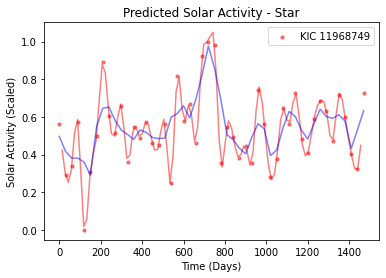

In [ ]:
plt.xlabel('Time (Days)')
plt.ylabel("Solar Activity (Scaled)")
plt.title('Predicted Solar Activity - Star')

exohost_fill = exohost_preds
print(len(exohost_fill))

maxlen = findMaxLen(exohost_fill)
lcx = np.arange(0,maxlen*30,30)

plt.autoscale(enable=True, axis='both', tight=None)

# for i in range(len(exohost_fill)):
#   plt.scatter(lcx,exohost_fill[i], s = 10, c='blue', alpha=0.5, label=("KIC"+str(exohost[i])))
#   x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[i]]).T,30)
#   plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5)
plt.scatter(lcx,exohost_fill[0], s = 10, c='red', alpha=0.5,label=("KIC "+str(experiment[0])))
# plt.scatter([0],[0], s = 8, c='black', alpha=0.5,label="Mathur et al. 2014 Prediction")
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[0]]).T,100)
y2_ITP = sm.nonparametric.lowess(exohost_fill[0],lcx,frac=0.1).T
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='red', alpha=0.5)
plt.plot(y2_ITP[0],y2_ITP[1], c='blue', alpha=0.5)

# plt.scatter(lcx,exohost_fill[1], s = 10, c='red', alpha=0.5, label=("KIC"+str(experiment[1])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[1]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='red', alpha=0.5)

# plt.scatter(lcx,exohost_fill[2], s = 10, c='green', alpha=0.5, label=("KIC"+str(exohost_fill[2])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[2]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='green', alpha=0.5)

# #plt.scatter(lcx,exohost_fill[3], s = 10, c='orange', alpha=0.5, label=("KIC"+str(exohost[3])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[3]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='orange', alpha=0.5)
# #plt.scatter(lcx,exohost_fill[4], s = 10, c='purple', alpha=0.5, label=("KIC"+str(exohost[4])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[4]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='purple', alpha=0.5)
# #plt.scatter(lcx,exohost_fill[5], s = 10, c='black', alpha=0.5, label=("KIC"+str(exohost[5])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[5]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='black', alpha=0.5)
# #plt.scatter(lcx,exohost_fill[6], s = 10, c='brown', alpha=0.5, label=("KIC"+str(exohost[6])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[6]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='brown', alpha=0.5)

# #plt.scatter(lcx,exohost_fill[7], s = 10, c='orange', alpha=0.5, label=("KIC"+str(exohost[7])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[7]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='orange', alpha=0.5)
# #plt.scatter(lcx,exohost_fill[8], s = 10, c='purple', alpha=0.5, label=("KIC"+str(exohost[8])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[8]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='purple', alpha=0.5)
# #plt.scatter(lcx,exohost_fill[9], s = 10, c='black', alpha=0.5, label=("KIC"+str(exohost[9])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[9]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='black', alpha=0.5)
# #plt.scatter(lcx,exohost_fill[10], s = 10, c='brown', alpha=0.5, label=("KIC"+str(exohost[10])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[10]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='brown', alpha=0.5)

# #plt.scatter(lcx,exohost_fill[11], s = 10, c='orange', alpha=0.5, label=("KIC"+str(exohost[11])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[11]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='orange', alpha=0.5)
# #plt.scatter(lcx,exohost_fill[12], s = 10, c='purple', alpha=0.5, label=("KIC"+str(exohost[12])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[12]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='purple', alpha=0.5)


# plt.scatter(lcx,exohost_fill[3], s = 10, c='purple', alpha=0.5, label=("KIC"+str(exohost[3])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[3]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='purple', alpha=0.5)



plt.legend()
plt.savefig('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Graphs/pred_lc.png')
plt.show()

## Compare Datasets

In [ ]:
#23
#   print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)

#24
#   print(BiSON_ts_24_fit.shape,SN_ts_24_fit.shape,LOI_ts_24.shape)

#Full
#   print(BiSON_ts_full_fit.shape,SN_ts_full_fit.shape,LOI_ts_full.shape)
y1 = normalize2D(BiSON_ts_full_fit)[0]
y2 = normalize2D(LOI_ts_full)[0]
y3 = lc1_prep[0]

NameError: ignored

In [ ]:
def filterPg(pg):
  discard = 0.3
  for i in range(int(len(pg))):
    if pg[i] <= discard:
      pg[i] = 0
  #   else:
  #     pg[i] -= discard
  # pg = np.divide(pg,np.max(pg))
  return pg

[ 992. 1380. 1622. 2132. 2916. 3371. 4148. 4526. 4939. 5290. 5836. 6571.
 6951. 7354.] [0.44721106 0.49577136 0.56318943 0.54038116 1.         0.39177608
 0.36370707 0.53226221 0.47128111 0.35626258 0.50778757 0.52390755
 0.55922793 0.35757202 0.44401813 0.04963992]
7776


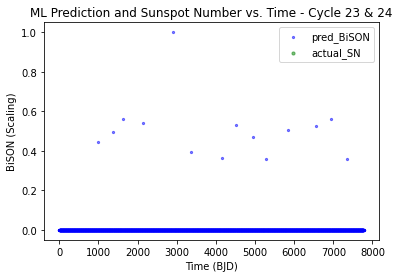

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')
# for i in range(len(y3)):
#   if y3[i] < 0.4:
#     y3[i] = 0
# print(y3[0])
  

x1 = np.arange(0,7776)

y4 = []
for value in x1:
    check = True
    for i in range(int(len(tfreqs))):
        if int(tfreqs[i]-1) == value:
            y4 = np.append(y4,tmodes[i])
            check = False
            break
    if check:
        y4 = np.append(y4,0)

print(len(y4))

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('BiSON (Scaling)')
axis_1.scatter(x1,y4, s = 5, c='blue', alpha=0.5, label="pred_BiSON")
# x1_ITP, y1_ITP = interpolate(np.array([x1,y1]).T,50)
# axis_1.plot(x1_ITP, y1_ITP, c='blue', alpha=0.5, label = "Pred. BiSON")

# # #Axis 2
# axis_2 = axis_1.twinx()
# axis_2.set_ylabel('LOI (Scaling)')
# axis_2.scatter(x1,y2, s = 5, c='red', alpha=0.5, label="pred_LOI")
# x2_ITP, y2_ITP = interpolate(np.array([x1,y2]).T,50)
# axis_1.plot(x2_ITP, y2_ITP, c='red', alpha=0.5, label = "Pred. LOI")

# #Axis 3
# axis_3 = axis_1.twinx()
# axis_3.axis("off")
# axis_3.set_ylabel('SN')
# axis_3.scatter(x1,y4, s = 5, c='green', alpha=0.5, label="actual_SN")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)
plt.show()

In [ ]:
lk.seismology.estimate_deltanu_acf2d?

## Test Code

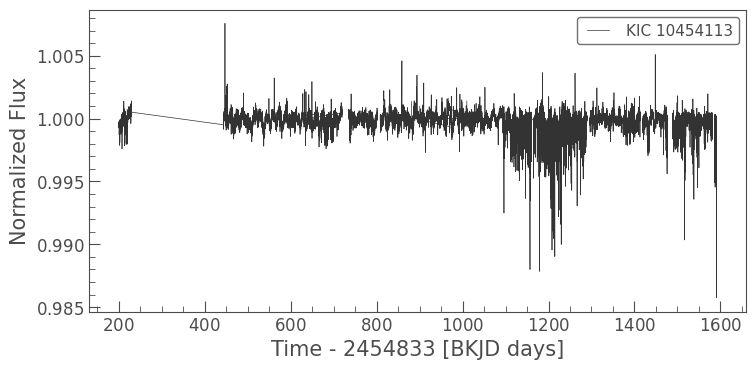

In [ ]:
search_result = lk.search_lightcurve('KIC 10454113', author='Kepler', cadence="short")
search_result
lc_test = search_result.download_all().stitch()
lc_test.plot()

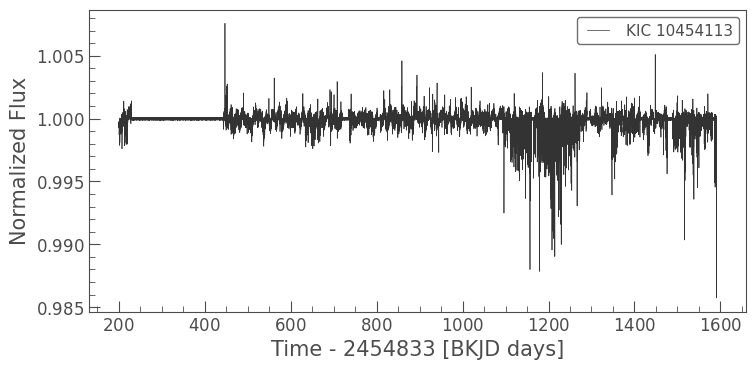

In [ ]:
lc_test = lc_test.fill_gaps()
lc_test.plot()

In [ ]:
Dlc_table = lc_test.to_table()
lc_array = np.array(lc_table['flux'])
print(lc_array)

In [ ]:
lcdatax = np.arange(0,len(lc_array)/1440,1/1440)
lcfull = np.append([lcdatax],[lc_array],0).T
print(lcfull.shape)

(1996170, 2)


In [ ]:
print(lcfull[-1])

[1.38622847e+03 1.00039232e+00]


In [ ]:
lc_power, lc_numax = tsPower(lcfull.T[0],lcfull.T[1],90,30)

In [ ]:
print(lc_power.shape,lc_numax)

(44, 7776) 1425


In [ ]:
lc_power_norm = normalize2D(lc_power)
print(np.max(lc_power_norm))

1.0


In [ ]:
pred_lc = model.predict(lc_power_norm[9:]).reshape(-1)
print(pred_lc.shape)
print(pred_lc)

(35,)
[2.1501856 2.1978247 2.218618  1.9813035 1.8138002 1.6447774 1.7670627
 1.3543344 1.6227567 1.4145533 1.6896728 1.8097239 1.6240644 2.0843878
 2.0923507 1.9381614 2.283571  2.4614487 2.109753  1.9923794 2.4358625
 2.504476  2.693074  2.2238019 2.4378045 2.00395   1.5316311 2.0904558
 1.6939368 1.8036245 1.837662  1.5059265 2.7730196 2.3647003 2.3227234]


<function matplotlib.pyplot.show>

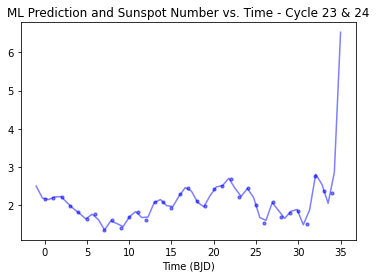

In [ ]:
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

lc_testx = np.arange(0,int(len(pred_lc)))

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(lc_testx,pred_lc, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc]).T,50)
plt.plot(x1_ITP, y1_ITP, c='blue', alpha=0.5, label = "Pred. BiSON")

plt.show

In [ ]:
lcdata3 = getData("KIC 6116048")

In [ ]:
lc_power, lc_numax = tsPower(lcdata3.T[0],lcdata3.T[1],90,30)

In [ ]:
lc_power_norm = normalize2D(lc_power)
print(np.max(lc_power_norm))

1.0


In [ ]:
pred_lc = model.predict(lc_power_norm[9:]).reshape(-1)
print(pred_lc.shape)
print(pred_lc)

(36,)
[0.5277961  0.63132465 0.40478465 0.42059588 0.5209544  0.7009002
 1.031577   0.7302094  0.58843035 0.5559162  0.57662654 0.58658266
 0.5535707  0.4052446  0.38021135 0.54982436 1.748396   1.4241097
 2.086725   1.1885546  1.8470598  1.8879963  1.9531791  1.8862461
 1.4063263  1.131757   1.1278707  1.4685751  1.067278   1.2002715
 1.1034241  0.6847471  0.71507204 1.2039894  1.3913287  1.1852996 ]


In [ ]:
lcdata4 = getData("KIC 12009504")

In [ ]:
lc_power2, lc_numax2 = tsPower(lcdata4.T[0],lcdata4.T[1],90,30)

In [ ]:
lc_power_norm2 = normalize2D(lc_power2)
print(np.max(lc_power_norm2))
pred_lc2 = model.predict(lc_power_norm2[9:-2]).reshape(-1)
print(pred_lc2.shape)
print(pred_lc2)

1.0
(36,)
[1.0906223  1.0631001  1.0119612  1.1853065  1.2532316  0.87308747
 0.9431411  0.9877703  1.6166066  1.683091   1.5640908  0.886065
 1.0997486  1.0799937  1.2167377  0.99084055 1.1682     1.0814201
 1.524697   1.6352017  1.7068578  1.4969152  0.9861238  1.2276504
 1.0122035  1.7186154  1.7474402  2.0638342  2.1568449  1.5226185
 1.688213   1.412455   1.489743   1.0179482  1.2917794  0.8883791 ]


In [ ]:
lcdata5 = getData("KIC 8006161")

In [ ]:
lc_power3, lc_numax3 = tsPower(lcdata5.T[0],lcdata5.T[1],90,30)

In [ ]:
lc_power_norm3 = normalize2D(lc_power3)
print(np.max(lc_power_norm3))
pred_lc3 = model.predict(lc_power_norm3[9:]).reshape(-1)
print(pred_lc3.shape)
print(pred_lc3)

1.0
(36,)
[0.51671636 0.4697245  0.5306659  0.4744122  0.5324677  0.8603418
 0.8463695  0.9316367  1.2206714  1.2951821  0.85572636 0.7345146
 0.80385494 0.774252   1.3114283  1.420307   1.7812022  1.5878102
 1.1935314  1.2851081  1.3955448  2.1604865  2.4565613  1.9691529
 1.7256997  1.3129588  1.7235616  1.5142536  1.7675918  1.2173353
 0.9837395  0.6535239  2.0073683  1.9211634  1.6827221  1.8208772 ]


<function matplotlib.pyplot.show>

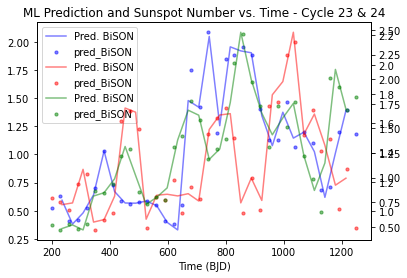

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

lc_testx = np.arange(200,int(len(pred_lc))*30+200,30)



#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.scatter(lc_testx,pred_lc, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc]).T,30)
axis_1.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5, label = "Pred. BiSON")


# #Axis 2
axis_2 = axis_1.twinx()
axis_2.scatter(lc_testx,pred_lc2, s = 10, c='red', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc2]).T,30)
axis_2.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='red', alpha=0.5, label = "Pred. BiSON")


# #Axis 3
axis_3 = axis_1.twinx()
axis_3.scatter(lc_testx,pred_lc3, s = 10, c='green', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc3]).T,30)
axis_3.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='green', alpha=0.5, label = "Pred. BiSON")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)


plt.show